# Machine Learning in Python - Project 2

Due Friday, April 15th by 5 pm UK local time.

In [1]:
# Add any additional libraries or submodules below

# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Ipython Display
from IPython.display import display, Markdown, HTML # Displays things nicely

# Keras
import tensorflow.keras as keras
import tensorflow_model_optimization as tfmot

# Calendar
from calendar import monthrange

# Scipy
import scipy.stats as stats

# LIME`
import lime.lime_tabular

2022-04-24 15:45:30.484467: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-24 15:45:30.484483: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Load data
d = pd.read_csv("hotel.csv")
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [3]:
def stayLengthCheck(df):
    # This function removes any bookings which have an impossible number of nights stayed.
    d=np.multiply([int(df["stays_in_week_nights"].loc[i]/5)-1<=int(df["stays_in_weekend_nights"].loc[i])/2 or
    int(df["stays_in_week_nights"].loc[i]/5)>=int(df["stays_in_weekend_nights"].loc[i])/2-1
    for i in df.index], 1)
    for i in df.index:
        if d[i]==0:
            df=df.drop(i)
    return df

display(Markdown("Number of bookings with illegal night numbers: "+str(d.shape[0]-stayLengthCheck(d).shape[0])))

Number of bookings with illegal night numbers: 0

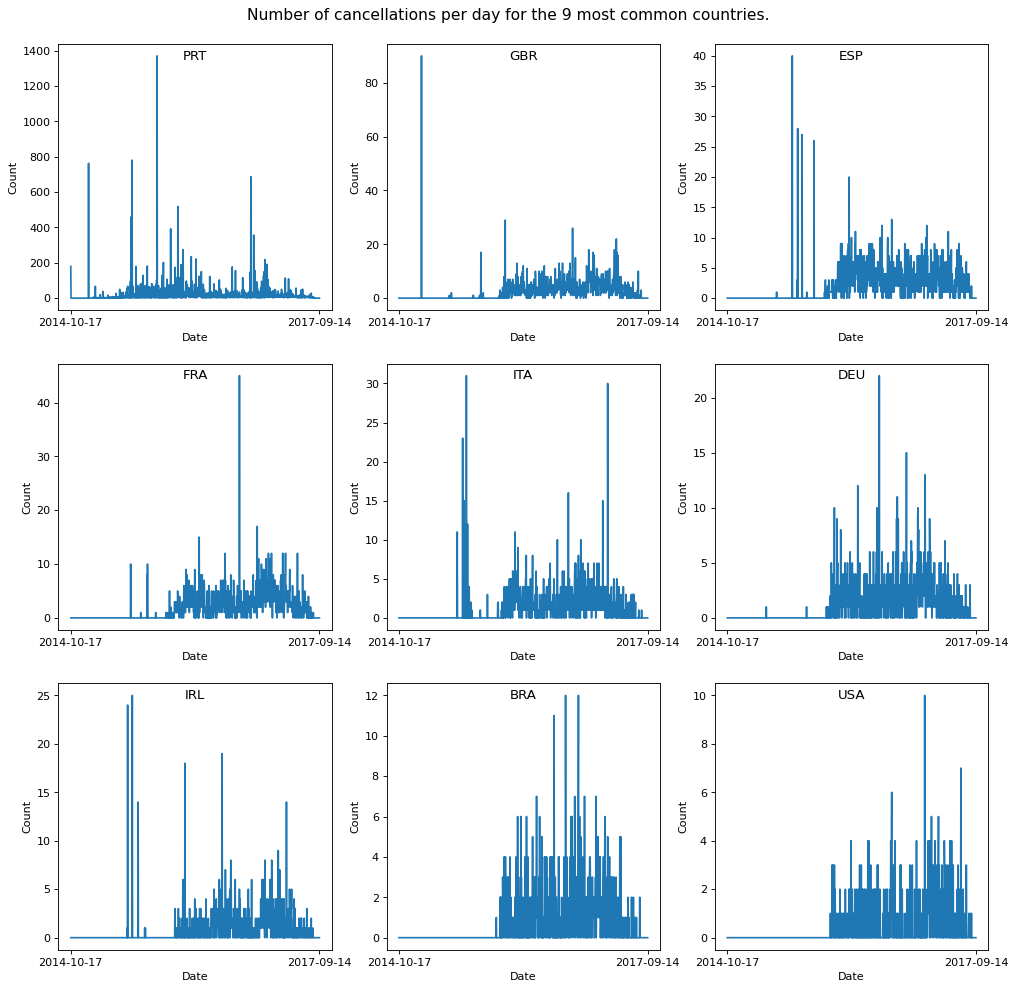

In [4]:
## Analysis for cancellation date in different countries
# Find the 9 countries with the most cancellations
df_ = d.drop(d[d["reservation_status"]=='Check-Out'].index)
df_ = df_.drop(df_[df_["reservation_status"]=='No-Show'].index)
countries = df_["country"].value_counts().sort_values(ascending=False).iloc[0:9]
countries = [a for a, b in zip(countries.index, countries)]

# Find when the cancellations are for these 9 countries
daterange = pd.date_range(start=d["reservation_status_date"].min(), end=d["reservation_status_date"].max())
datesList = []
for cou in countries:
    df2 = df_.drop(df_[df_["country"]!=cou].index)
    dates = df2["reservation_status_date"].value_counts()
    datesdf=pd.DataFrame()
    datesdf["date"] = pd.to_datetime(dates.index)
    datesdf["count"] = dates.to_numpy()
    datesdf.index=datesdf["date"]
    datesdf.index.name=None
    for i in daterange:
        if not i in datesdf.index:
            datesdf.loc[i]=[i, 0]
    datesdf = datesdf.sort_values(by="date", axis=0)
    datesdf = datesdf.drop("date", axis=1)  
    datesList.append(datesdf)
    #display(Markdown(r"Most common day for "+cou+" was: "+str(datesdf["count"].idxmax()).split(" ")[0]
    #                 +" with: "+str(datesdf["count"].max())+" cancellations."))
    
# Plot data
fig, axs = plt.subplots(3, 3, figsize=(15,15))
axs = axs.flatten()
fig.suptitle('Number of cancellations per day for the 9 most common countries.', fontsize=14, y=0.91)
for cou, ax, i in zip(countries, axs, range(len(axs))):
    ax.plot(daterange, datesList[i]["count"])
    ax.set_title(cou, y=1.0, pad=-14)
    ax.set_ylabel("Count")
    ax.set_xlabel("Date")
    ax.set_xticks([daterange[0], daterange[-1]])
plt.show()

In [6]:
def remove_only_babies(df): 
    # Keeping rows where adults+children != 0, removes 180 rows 
    df = df[df.adults + df.children != 0]
    return df

def mealNum(df):
    # Changes meals into numbers
    meal_dict={'FB':3,
               'HB':2,
               'BB':1,
               'SC':0,
               'Undefined':0
              }
    df["meal"]=df["meal"].map(meal_dict)
    return df

def oneHotEncoding(df, N=10):
    # This function completes onehotencoding for the following columns:
    OHECols = ["country", "market_segment", "distribution_channel", "deposit_type",
              "customer_type", "agent", "company", "arrival_date_year"]
    OHEs = []
    for i in OHECols:
        OHEnew = pd.get_dummies(df[i], prefix=i, prefix_sep=": ")
        for j in OHEnew.columns:
            if OHEnew[j].sum()<=N:
                OHEnew = OHEnew.drop(j, axis=1)
        OHEs.append(OHEnew)
    for i in ["agent", "company"]:
        df[i]=[0 if np.isnan(df[i].iloc[c]) else 1 for c in range(len(df[i]))]
    return pd.concat([df, *OHEs], axis=1).drop(["country", "market_segment", "distribution_channel",
                                                "deposit_type", "customer_type"], axis=1)

def room_type(df):
    # This function gets rid of the old room types and replaces them with correct_room
    df["correct_room"]= np.multiply(df["reserved_room_type"]==df["assigned_room_type"], 1)
    return df.drop(["reserved_room_type", "assigned_room_type"], axis=1)

def inCity(df):
    # We turn hotel into "inCity"
    df["inCity"]=[int(df["hotel"].iloc[i]=='Resort Hotel') for i in range(len(df["hotel"]))]
    return df.drop("hotel", axis=1)

# Create a dictionary of month lengths for each year
month_dict_nonleap = {'January': 0, 'February': 31, 'March': 59, 'April': 90, 
              'May': 120, 'June': 151, 'July': 181, 'August': 212,
              'September': 243, 'October': 273, 'November': 304, 'December': 334}
month_dict_leap = {'January': 0, 'February': 31, 'March': 60, 'April': 91, 
              'May': 121, 'June': 151, 'July': 181, 'August': 213,
              'September': 244, 'October': 274, 'November': 305, 'December': 335}   

def arrivalDate(df):
    # This function changes arrival date columns into one "day of year" column
    xs = []
    for i in range(len(df["inCity"])):
        if df["arrival_date_year"].iloc[i]==2016:
            mon = month_dict_leap[df["arrival_date_month"].iloc[i]]
            xs.append(mon + df["arrival_date_day_of_month"].iloc[i])
        else:
            mon = month_dict_nonleap[df["arrival_date_month"].iloc[i]]
            xs.append(mon + df["arrival_date_day_of_month"].iloc[i])
    df["arrival_day"]=xs
    return df.drop(["arrival_date_month",
                    "arrival_date_week_number", "arrival_date_day_of_month"],
                   axis=1)

def dropUndefinedRows(df):
    # This function removes rows with 'Undefined' in the following columns:
    cols = ["market_segment", "distribution_channel"]
    for c in cols:
        toDrop = df.index[df[c]=='Undefined'].tolist()
        df=df.drop(toDrop, axis=0)
    return df

def stayLengthCheck(df): # BROKEN
    # This function checks that the weekend and weekday lengths don't have inalid values.
    for i in range(len(df["inCity"])):
        if (df["stays_in_week_nights"].iloc[i]+df["stays_in_weekend_nights"].iloc[i])==0:
            df=df.drop(df.iloc[i].name, axis=0)
        elif df["stays_in_weekend_nights"].iloc[i]>2 and df["stays_in_week_nights"].iloc[i]<5:
            df=df.drop(df.iloc[i].name, axis=0)
        elif df["stays_in_weekend_nights"].iloc[i]<2 and df["stays_in_week_nights"].iloc[i]>5:
            df=df.drop(df.iloc[i].name, axis=0)
    return df

def outliers(X, y, threshold):
    # This function removes outliers
    X = pd.DataFrame(X)
    y = pd.DataFrame(y)
    xs = []
    z = np.abs(stats.zscore(X))
    z = (z>=threshold)
    z = np.sum(z, axis=1).to_numpy()
    for i in range(z.shape[0]):
        if z[i]>=3:
            xs.append(i)
    return X.drop(X.index[[*xs]]).to_numpy(), y.drop(y.index[[*xs]]).to_numpy()

def previousActivity(df):
    df["total_previous_bookings"]=df["previous_bookings_not_canceled"]+df["previous_cancellations"]
    xs = []
    for i in df.index:
        if df["total_previous_bookings"].loc[i]==0:
            xs.append(0)
        else:
            xs.append(df["previous_cancellations"].loc[i]/df["total_previous_bookings"].loc[i])
    df["cancellation_rate"]=xs
    return df.drop(["previous_bookings_not_canceled", "previous_cancellations", "is_repeated_guest"], axis=1)

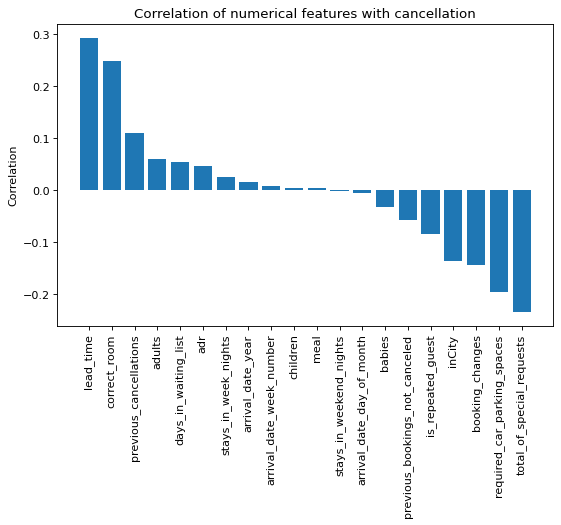

In [7]:
b=room_type(mealNum(inCity(d.drop(["arrival_date_month", "country", "agent", "company",
          "market_segment", "distribution_channel",
          "deposit_type", "customer_type",
          ], axis=1)))).corr()['is_canceled'].sort_values(ascending = False)

b=b.drop("is_canceled")
b=plt.bar(b.index, b.to_numpy())
b=plt.xticks(rotation=90)
b=plt.ylabel("Correlation")
b=plt.title("Correlation of numerical features with cancellation")

In [8]:
def dropDuplicatesZScore(X, y):
    ## This function is designed to take the training set and remove duplicates based on zscores
    # Turn the training set into a dataframe
    X = pd.DataFrame(X)
    y = y.reset_index(drop=True)
    y.name = 'y' # Distinguishes the target feature from other features
    df = pd.concat([X, y], axis=1)
    
    # Finds the zscore for each row and then standardises
    z = np.abs(stats.zscore(X))
    z = np.sum(z, axis=1).to_numpy()/len(df.columns)
    
    # Group the indices duplicate rows with each other in a big list
    df_ = df[df.duplicated(keep=False)]
    dupsList = df_.groupby(list(df_.columns)).apply(lambda x: list(x.index)).tolist()
    dupsList = [x for x in dupsList if len(x)>2]
    
    # Decide how much of each set to drop
    toDrop = []
    for x in dupsList:
        x = x[1:int(len(x)*z[x[0]])] # Note that index 0 is always preserved
        if len(x)!=0:
            toDrop.append(list(x))
            
    # Drop all rows which we decide to drop
    df = df.drop([i for s in toDrop for i in s])

    return df.drop("y", axis=1).to_numpy(), df['y'].to_numpy()

In [9]:
def numericalResStatus(df):
    ## Change the reservation status columns into numerical columns
    df["reservation_status_date"]=pd.to_datetime(df["reservation_status_date"]).dt.strftime("%Y%m%d").astype(int)
    status = {'Check-Out':0, 'Canceled':1, 'No-Show':2}
    df["reservation_status"]=[status[df["reservation_status"].loc[i]] for i in df.index]
    return df

def dropResStatus(X, cols):
    ## Drop the reservation status columns
    X = pd.DataFrame(X)
    X.columns=cols
    return X.drop(["reservation_status","reservation_status_date"], axis=1).to_numpy()

In [10]:
L = 100 # Any OHE columns with sum leq to this value will be dropped.
df = d.copy()
df = numericalResStatus(previousActivity(arrivalDate(inCity(room_type(oneHotEncoding(mealNum(remove_only_babies(dropUndefinedRows(df))), L))))))
df = df.dropna().astype(np.float32)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119205 entries, 0 to 119389
Columns: 175 entries, is_canceled to cancellation_rate
dtypes: float32(175)
memory usage: 84.5 MB


In [11]:
# Test-train split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
std = StandardScaler()
#std = MinMaxScaler()
X = df.drop('is_canceled',axis=1) # Independent variable
y = df['is_canceled'] # dependent variable

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=23)

# Standardise all variables
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

# This drops the duplicate values with high z-scores
X_train, y_train = dropDuplicatesZScore(X_train, y_train)

# Remove the Reservation status features from X_train and X_test
X_train = dropResStatus(X_train, X.columns)
X_test = dropResStatus(X_test, X.columns)

# Remove outliers from training set
X_train, y_train = outliers(X_train, y_train, 3)

In [12]:
# Fit model
K = X_train.shape[1]
model = keras.Sequential()
model.add(keras.layers.Dense(K, input_shape=(K,), activation='relu'))
#model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(int(K*2/3), activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(int(K*2/3), activation='relu'))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x=X_train, y=y_train, epochs=10, shuffle=True, validation_split=0.1)

Epoch 1/10


2022-04-24 15:46:08.962610: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-24 15:46:08.962627: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-24 15:46:08.962643: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (frame-work-wb): /proc/driver/nvidia/version does not exist
2022-04-24 15:46:08.963048: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2572/2572 [==============================] - 3s 1ms/step - loss: 0.3535 - accuracy: 0.8294 - val_loss: 0.3311 - val_accuracy: 0.8449
Epoch 2/10
2572/2572 [==============================] - 3s 1ms/step - loss: 0.3189 - accuracy: 0.8472 - val_loss: 0.3015 - val_accuracy: 0.8527
Epoch 3/10
2572/2572 [==============================] - 3s 1ms/step - loss: 0.3081 - accuracy: 0.8537 - val_loss: 0.2979 - val_accuracy: 0.8588
Epoch 4/10
2572/2572 [==============================] - 3s 1ms/step - loss: 0.2993 - accuracy: 0.8579 - val_loss: 0.2957 - val_accuracy: 0.8587
Epoch 5/10
2572/2572 [==============================] - 3s 1ms/step - loss: 0.2937 - accuracy: 0.8616 - val_loss: 0.2900 - val_accuracy: 0.8633
Epoch 6/10
2572/2572 [==============================] - 3s 1ms/step - loss: 0.2874 - accuracy: 0.8640 - val_loss: 0.2859 - val_accuracy: 0.8648
Epoch 7/10
2572/2572 [==============================] - 3s 1ms/step - loss: 0.2829 - accuracy: 0.8665 - val_loss: 0.2790 - val_accuracy: 0.8713
Epo

RMSE: 0.296

Accuracy for test set: 0.874

Naive guess accuracy: 0.625

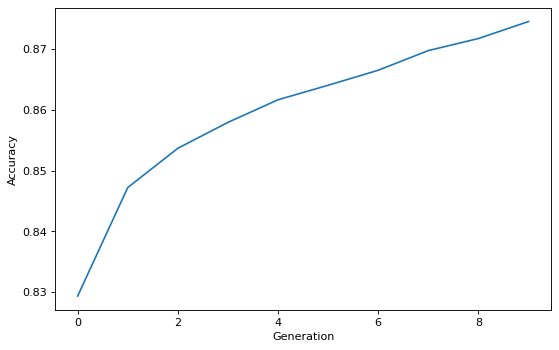

In [13]:
# Plot Accuracy over generations
plt.plot(history.history['accuracy'])
plt.xlabel("Generation")
plt.ylabel("Accuracy")
# Find test results
y_test_hat = model.predict(x=X_test).flatten()
y_test_hat_exact = np.round(y_test_hat)
number_correct = np.sum([int(i==j) for i, j in zip(y_test_hat_exact, y_test)])
number_correct_naive = len(y_test)-np.sum(y_test)
display(Markdown(r"RMSE: "+str(np.round(np.sqrt(np.mean((y_test_hat-y_test)**2)), 3))))
display(Markdown(r"Accuracy for test set: "+str(np.round(number_correct/len(y_test), 3))))
display(Markdown(r"Naive guess accuracy: "+str(np.round(number_correct_naive/len(y_test), 3))))

### Model Configuration Testing
Using only 5 generations we check different loss and optimizer functons:
* `loss='mse'` and `optimizer='adam'` gives `RMSE: 0.304`
* `loss='binary_crossentropy'` and `optimizer='adam'` gives `RMSE=0.3`

Now, we try messing with 'Dropout' with the same 5 generations:
* `Dropout(0.1)` gives `RMSE: 0.3`
* `Dropout(0.2)` gives `RMSE: 0.301`
* `Dropout(0.5)` gives `RMSE: 0.305`
* `Dropout(0.0)` gives `RMSE: 0.304`

Finally, lets test the current model for 50 generations:
* `Dropout(0.1)`, `loss=binary_crossentropy` and `optimizer=adam` gives `RMSE: 0.326`
* `Dropout(0.5)`, `loss=binary_crossentropy` and `optimizer=adam` gives `RMSE: 0.319`

From these results I think we can conclude that the model is still overlearning. This could be solved by even more dropouts but I think that it is more indicative of unclean data.

I tried adding an extra layer of Dropout between hidden 1 and input and ran for 5 generations:
* `Dropout(0.20)` and `Dropout(0.20)` gives `RMSE: 0.303`
* `Dropout(0.25)` and `Dropout(0.25)` gives `RMSE: 0.305`
* `Dropout(0.40)` and `Dropout(0.20)` gives `RMSE: 0.304`

### Feature Importance
The following cells use LIME to predict which features contribute to each outcome. Set `N` to the number of test cases you want to look at. On my laptop `N=100` takes several minutes to run.

In [14]:
X_test=pd.DataFrame(X_test)
X_col = X.drop(["reservation_status", "reservation_status_date"], axis=1).columns
X_test.columns=X_col
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11921 entries, 0 to 11920
Columns: 172 entries, lead_time to cancellation_rate
dtypes: float32(172)
memory usage: 7.8 MB


In [15]:
# List of items from the testing set to check
testList = [np.random.randint(0, X_test.shape[0]-1) for i in range(10)]
#testList = [X_test["lead_time"].idxmax()]
testList

[6534, 6682, 957, 7960, 647, 10185, 9241, 6045, 3861, 5122]

In [16]:
N=len(testList)
explainer=lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=X.columns, class_names=[0, 1], mode='classification')
imp_averages = dict([(k, 0) for k in range(len(X.columns))])
for i in testList:
    exp = explainer.explain_instance(X_test.loc[i], model.predict, num_features=len(X.columns), top_labels=1)
    imp = exp.as_map()[0]
    for k, i in imp:
        imp_averages[k]+=i

for k in imp_averages:
    imp_averages[k]=imp_averages[k]/N

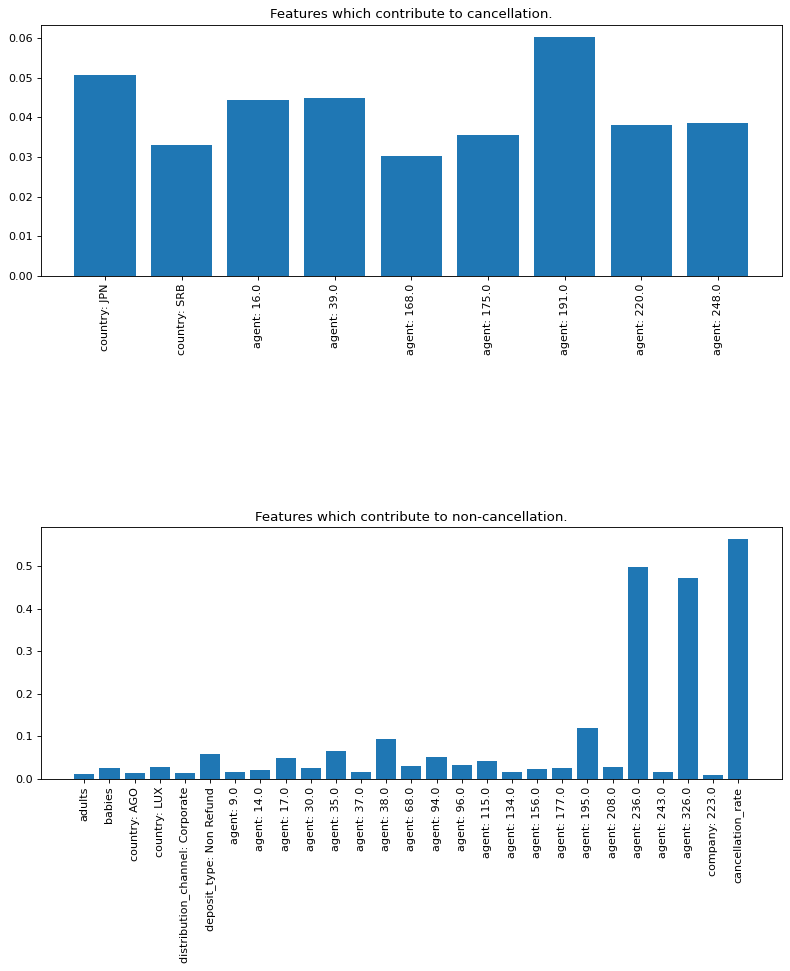

In [20]:
imp_plus = {}
imp_minus= {}
for k in imp_averages:
    i = imp_averages[k]
    if i>=0.03:
        imp_plus[X_col[k]]=i
    if i<=-0.01:
        imp_minus[X_col[k]]=abs(i)
      
fig, axs =  plt.subplots(2, 1, figsize=(10,10))
fig.tight_layout()
axs[0].bar(range(len(imp_plus)), list(imp_plus.values()), align='center')
axs[0].set_xticks(range(len(imp_plus)), list(imp_plus.keys()), rotation=90)
axs[0].set_title("Features which contribute to cancellation.")
axs[1].bar(range(len(imp_minus)), list(imp_minus.values()), align='center')
axs[1].set_xticks(range(len(imp_minus)), list(imp_minus.keys()), rotation=90)
axs[1].set_title("Features which contribute to non-cancellation.")
plt.subplots_adjust(hspace = 1)